# Analysis of v-Abl proB DMSO STI+ 2 color

by Pu Zheng

2021.4.2

1. EM algorithm has been updated.

# 0. required packages for h5py

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

3456


# 1. Create field-of-view class

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(External.Fitting_v4)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

<module 'ImageAnalysis3.spot_tools.fitting' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\spot_tools\\fitting.py'>

## 1.1 set parameters

In [3]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color',
             'save_folder':r'\\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,23)

## 1.2 process images into spots

In [4]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite_spots = False
overwrite_chrom = False
intensity_th = 150

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []
cand_fov_ids = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite_spots,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_type='reverse', 
                                          _overwrite=overwrite_chrom)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.75, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite_chrom)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.25,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite_chrom)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    cand_fov_ids += list(np.ones(len(fov_cand_chr_spots_list), dtype=np.int) * _fov_id)
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 63
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 74 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_03.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 5.656s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_03.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading seg

E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


kept chromosomes: 582
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 63
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 74 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_04.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 5.548s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_04.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from s

-- checking unique, region:[86 77] in 0.016s.
-- checking unique, region:[92 83] in 0.027s.
-- checking unique, region:[98 89] in 0.034s.
-- checking unique, region:[104  95] in 0.075s.
-- checking unique, region:[110 101] in 0.003s.
-- checking unique, region:[325 107] in 0.016s.
-- checking unique, region:[331 113] in 0.015s.
-- checking unique, region:[341 328] in 0.000s.
-- checking unique, region:[347 334] in 0.016s.
-- checking unique, region:[345 343] in 0.016s.
-- checking unique, region:[348 346] in 0.047s.
-- checking unique, region:[351 349] in 0.010s.
-- checking unique, region:[354 352] in 0.000s.
-- checking unique, region:[357 355] in 0.017s.
-- checking unique, region:[360 358] in 0.011s.
-- checking unique, region:[363 361] in 0.008s.
-- checking unique, region:[366 364] in 0.008s.
-- checking unique, region:[369 367] in 0.008s.
-- checking unique, region:[372 370] in 0.008s.
-- checking unique, region:[375 373] in 0.009s.
-- checking unique, region:[379 376] in 0.008s

kept chromosomes: 625
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 63
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 74 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_07.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 5.597s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_07.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from s

-- checking unique, region:[98 89] in 0.016s.
-- checking unique, region:[104  95] in 0.031s.
-- checking unique, region:[110 101] in 0.027s.
-- checking unique, region:[325 107] in 0.017s.
-- checking unique, region:[331 113] in 0.331s.
-- checking unique, region:[341 328] in 0.000s.
-- checking unique, region:[347 334] in 0.042s.
-- checking unique, region:[345 343] in 0.019s.
-- checking unique, region:[348 346] in 0.012s.
-- checking unique, region:[351 349] in 0.010s.
-- checking unique, region:[354 352] in 0.010s.
-- checking unique, region:[357 355] in 0.010s.
-- checking unique, region:[360 358] in 0.008s.
-- checking unique, region:[363 361] in 0.008s.
-- checking unique, region:[366 364] in 0.008s.
-- checking unique, region:[369 367] in 0.009s.
-- checking unique, region:[372 370] in 0.004s.
-- checking unique, region:[375 373] in 0.000s.
-- checking unique, region:[379 376] in 0.014s.
-- checking unique, region:[382 380] in 0.000s.
-- checking unique, region:[388 383] in 0.

kept chromosomes: 602
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 63
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 74 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_10.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 5.288s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_10.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from s

-- checking unique, region:[104  95] in 0.031s.
-- checking unique, region:[110 101] in 0.019s.
-- checking unique, region:[325 107] in 0.013s.
-- checking unique, region:[331 113] in 0.010s.
-- checking unique, region:[341 328] in 0.010s.
-- checking unique, region:[347 334] in 0.011s.
-- checking unique, region:[345 343] in 0.009s.
-- checking unique, region:[348 346] in 0.023s.
-- checking unique, region:[351 349] in 0.016s.
-- checking unique, region:[354 352] in 0.000s.
-- checking unique, region:[357 355] in 0.014s.
-- checking unique, region:[360 358] in 0.000s.
-- checking unique, region:[363 361] in 0.016s.
-- checking unique, region:[366 364] in 0.016s.
-- checking unique, region:[369 367] in 0.000s.
-- checking unique, region:[372 370] in 0.016s.
-- checking unique, region:[375 373] in 0.000s.
-- checking unique, region:[379 376] in 0.016s.
-- checking unique, region:[382 380] in 0.000s.
-- checking unique, region:[388 383] in 0.016s.
-- checking unique, region:[391 386] in 

kept chromosomes: 602
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 63
- Importing csv file: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 74 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_13.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 5.586s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_13.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from s

-- checking unique, region:[347 334] in 0.047s.
-- checking unique, region:[345 343] in 0.000s.
-- checking unique, region:[348 346] in 0.328s.
-- checking unique, region:[351 349] in 0.016s.
-- checking unique, region:[354 352] in 0.000s.
-- checking unique, region:[357 355] in 0.016s.
-- checking unique, region:[360 358] in 0.016s.
-- checking unique, region:[363 361] in 0.000s.
-- checking unique, region:[366 364] in 0.016s.
-- checking unique, region:[369 367] in 0.016s.
-- checking unique, region:[372 370] in 0.000s.
-- checking unique, region:[375 373] in 0.031s.
-- checking unique, region:[379 376] in 0.016s.
-- checking unique, region:[382 380] in 0.000s.
-- checking unique, region:[388 383] in 0.016s.
-- checking unique, region:[391 386] in 0.000s.
-- checking unique, region:[394 389] in 0.016s.
-- checking unique, region:[90 91] in 0.016s.
-- checking unique, region:[93 94] in 0.000s.
-- checking unique, region:[96 97] in 0.016s.
-- checking unique, region:[ 99 100] in 0.000s

E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 610 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 629.172s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_15.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.018s.
+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_15.hdf5
++ finish loading unique in 0.194s. 
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_15.hdf5
++ base attributes loaded:[] in 5.238s.
- start select from 610 chromosomes with loss threshold=0.25
-- remove chr id 348, percentage of lost rounds:0.347.
-- remove chr id 498, percentage of lost rounds:0.333.
-- 608 chromosomes are kept.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_15.hdf5
++ base

-- checking unique, region:[84 85] in 0.016s.
-- checking unique, region:[87 88] in 0.000s.
-- checking unique, region:[114 115] in 0.015s.
-- checking unique, region:[323 321] in 0.005s.
-- checking unique, region:[326 324] in 0.004s.
-- checking unique, region:[329 327] in 0.004s.
-- checking unique, region:[332 330] in 0.006s.
-- checking unique, region:[335 333] in 0.005s.
-- checking unique, region:[339 337] in 0.005s.
-- checking unique, region:[342 340] in 0.006s.
+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 

-- No folder selected, allow processing all 74 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H0R0\Conv_zscan_17.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H0R0\Conv_zscan_17.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H0R0\Conv_zscan_17.dax  in 8.015s
-- removing hot pixels for channels:['488'] in 8.512s
-- illumination correction for channels: 488, in 1.859s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 18.782s
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_17.hdf5
++ base attributes saved:['ref_im'] in 5.156s.
-- checking unique, region:[353 344] in 0.047s.
-- checking unique, region:[359 3

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_18.dax: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_18.hdf5.
* create savefile: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_18.hdf5
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_18.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'colo

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 4217.36s.
-- choose chrom images from folder: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H73R0_chrom.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H73R0_chrom\Conv_zscan_18.dax
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H73R0_chrom\Conv_zscan_18.dax  in 7.250s
-- removing hot pixels for channels:['647', '488'] in 17.797s
-- illumination correction for channels: 647, 488, in 3.781s
-- apply bead_drift calculate for channel: 488
-- aligning image -> directly use image
-- directly use ref_image
--- finish drift in 69.2

-- checking unique, region:[357 355] in 0.016s.
-- checking unique, region:[360 358] in 0.000s.
-- checking unique, region:[363 361] in 0.000s.
-- checking unique, region:[366 364] in 0.016s.
-- checking unique, region:[369 367] in 0.005s.
-- checking unique, region:[372 370] in 0.005s.
-- checking unique, region:[375 373] in 0.005s.
-- checking unique, region:[379 376] in 0.006s.
-- checking unique, region:[382 380] in 0.005s.
-- checking unique, region:[388 383] in 0.006s.
-- checking unique, region:[391 386] in 0.006s.
-- checking unique, region:[394 389] in 0.005s.
-- checking unique, region:[90 91] in 0.005s.
-- checking unique, region:[93 94] in 0.006s.
-- checking unique, region:[96 97] in 0.005s.
-- checking unique, region:[ 99 100] in 0.005s.
-- checking unique, region:[102 103] in 0.006s.
-- checking unique, region:[105 106] in 0.005s.
-- checking unique, region:[108 109] in 0.000s.
-- checking unique, region:[111 112] in 0.000s.
-- checking unique, region:[41 42] in 0.016s.


-- saving 405_illumination profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5.
-- saving 750_chromatic profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5.
-- saving 647_chromatic profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5.
-- 647_chromatic_constants profile already exist in save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5, skip.
-- saving 750_647_bleed profile to save_file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5.
-- saving unique to file: \\10.245.74.212\Chromat

++ base attributes loaded:[] in 4.985s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.75%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 602 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 460.985s.
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.125s.
+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5
++ finish loading unique in 0.359s. 
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_20.hdf5
++ base attributes loaded:[] in 5.859s.
- start select from 602 chromosomes with loss threshold=0.25
-- remove chr id 214, percentage of lost rounds:0

-- checking unique, region:[78 79] in 0.000s.
-- checking unique, region:[81 82] in 0.012s.
-- checking unique, region:[84 85] in 0.005s.
-- checking unique, region:[87 88] in 0.005s.
-- checking unique, region:[114 115] in 0.005s.
-- checking unique, region:[323 321] in 0.005s.
-- checking unique, region:[326 324] in 0.005s.
-- checking unique, region:[329 327] in 0.005s.
-- checking unique, region:[332 330] in 0.005s.
-- checking unique, region:[335 333] in 0.005s.
-- checking unique, region:[339 337] in 0.005s.
-- checking unique, region:[342 340] in 0.005s.
+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 3

-- No folder selected, allow processing all 74 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H0R0\Conv_zscan_22.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H0R0\Conv_zscan_22.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_1\20210326-proB_STI_DMSO_CTP-08_2color\H0R0\Conv_zscan_22.dax  in 8.326s
-- removing hot pixels for channels:['488'] in 8.578s
-- illumination correction for channels: 488, in 1.859s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 19.172s
-- saving fov_info to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Conv_zscan_22.hdf5
++ base attributes saved:['ref_im'] in 5.937s.
-- checking unique, region:[353 344] in 0.016s.
-- checking unique, region:[359 3

In [8]:
# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids
dna_reg_channels = fov.unique_channels

print(f"{len(chrom_coords)} chromosomes are found.")

11966 chromosomes are found.


In [6]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.8 # 80% of regions should have candidate spots

sel_dna_cand_hzxys_list = []
sel_chrom_coords = []
chr_cand_pers = []
sel_chr_cand_pers = []
sel_cand_fov_ids = []

for _cand_hzxys, _chrom_coord, _fov_id in zip(dna_cand_hzxys_list, chrom_coords, cand_fov_ids):
    _chr_cand_per = 0
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th)])
            _chr_cand_per += 1
    
    _chr_cand_per *= 1/len(_cand_hzxys)
    # append
    if _chr_cand_per >= good_chr_th:
        sel_dna_cand_hzxys_list.append(_sel_cands_list)
        sel_chrom_coords.append(_chrom_coord)
        sel_chr_cand_pers.append(_chr_cand_per)
        sel_cand_fov_ids.append(_fov_id)
        
    chr_cand_pers.append(_chr_cand_per)
    
print(f"kept chromosomes: {len(sel_chrom_coords)}")

kept chromosomes: 11950


## 2. EM pick spots

+ iter:0
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 45.500s
--- collapse all regions into 1d.


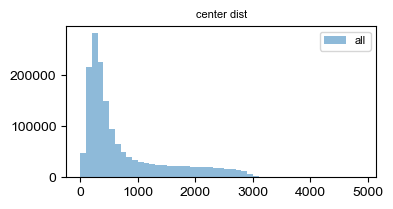

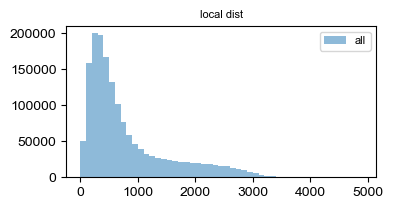

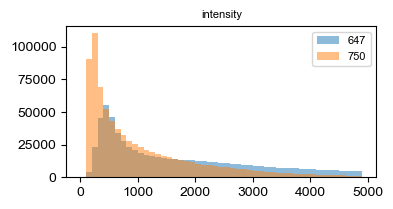

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 47.422s
-- region kept: 0.7851


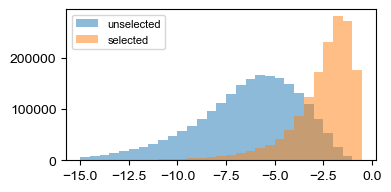

+ iter:1
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 32.750s
--- collapse all regions into 1d.


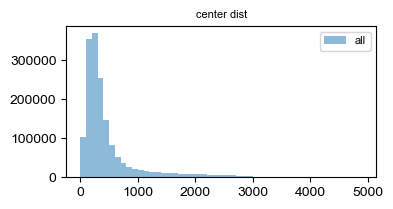

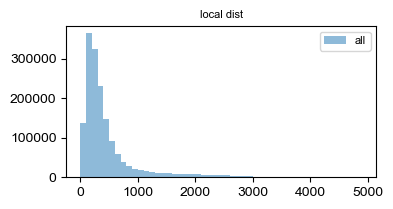

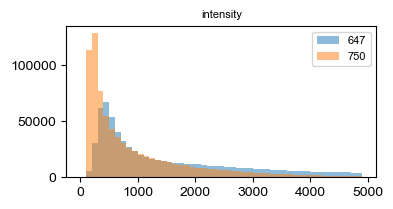

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 47.047s
-- region kept: 0.9527


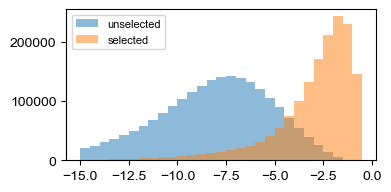

+ iter:2
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 32.595s
--- collapse all regions into 1d.


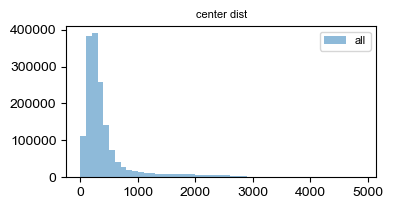

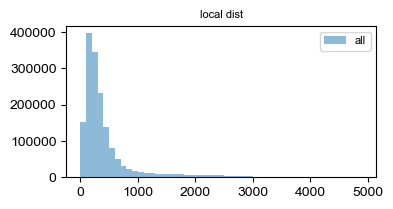

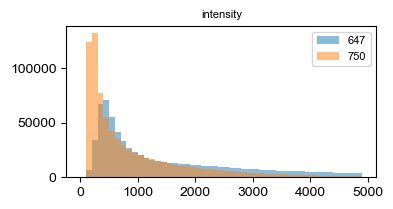

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 47.969s
-- region kept: 0.9872


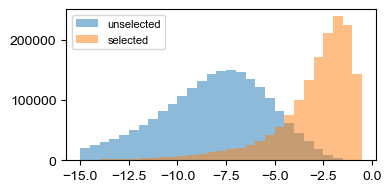

+ iter:3
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 32.610s
--- collapse all regions into 1d.


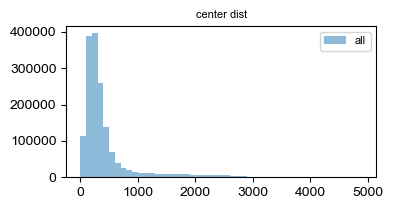

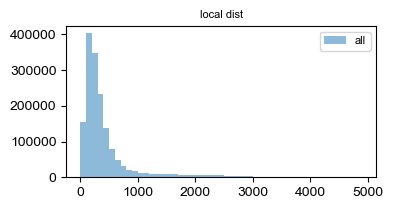

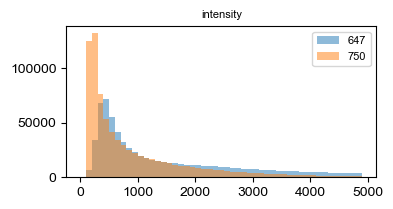

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 48.172s
-- region kept: 0.9950


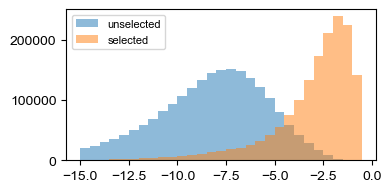

+ iter:4
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 32.922s
--- collapse all regions into 1d.


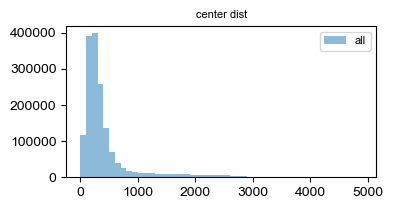

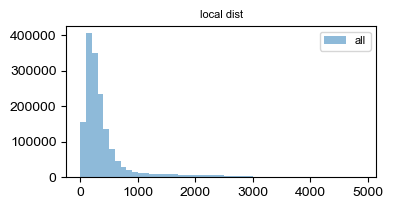

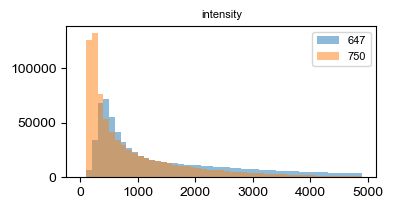

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 48.547s
-- region kept: 0.9974


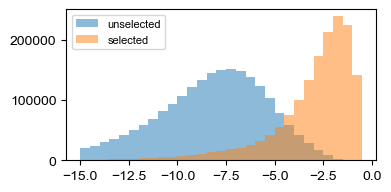

+ iter:5
-- generate reference metrics
--- multiprocessing expectation step with 32 threads, in 32.578s
--- collapse all regions into 1d.


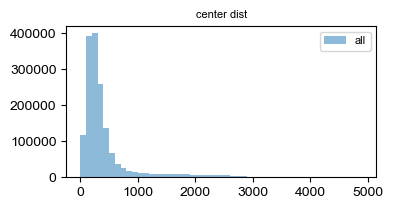

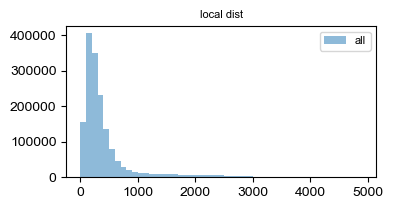

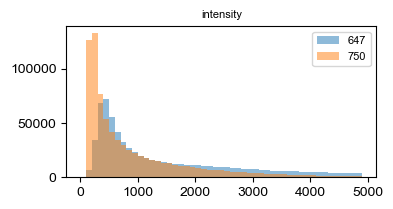

- pick spots by scores
--- multiprocessing maximization step with 32 threads, in 48.016s
-- region kept: 0.9984


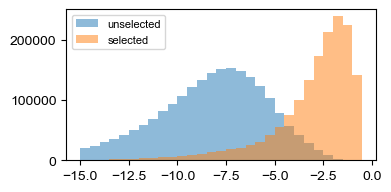

In [7]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 32
ref_chr_cts = None
# initialize
init_dna_hzxys = pick_spots_by_intensities(sel_dna_cand_hzxys_list)
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list, other_dna_scores_list = [init_dna_hzxys], [], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1], dna_reg_ids,
        ref_channels=dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    sel_hzxys_list, sel_scores_list, all_scores_list, other_scores_list = \
    pick_spots_by_scores(
        sel_dna_cand_hzxys_list, dna_reg_ids,
        cand_channels=dna_reg_channels, 
        ref_hzxys_list=sel_dna_hzxys_list[-1], ref_ids=dna_reg_ids, ref_channels=dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(sel_hzxys_list, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_dna_hzxys_list.append(sel_hzxys_list)
    sel_dna_scores_list.append(sel_scores_list)
    all_dna_scores_list.append(all_scores_list)
    other_dna_scores_list.append(other_scores_list)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in other_scores_list]), 
             bins=np.arange(-15, 0, 0.5), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_sel_scores) 
                       for _sel_scores in sel_dna_scores_list[-1]]), 
             bins=np.arange(-15, 0, 0.5), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

In [16]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = -4.5
int_th = 300
bad_spot_percentage = 1

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    # remove spots by intensity
    _bad_inds = _kept_hzxys[:,0] < int_th
    # remove spots by scores
    _bad_inds += _scores < score_th
    #print(np.mean(_bad_inds))
    _kept_hzxys[_bad_inds] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
kept_chrom_coords = np.array(sel_chrom_coords)[kept_chr_ids]
kept_fov_ids = np.array(sel_cand_fov_ids)[kept_chr_ids]

distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

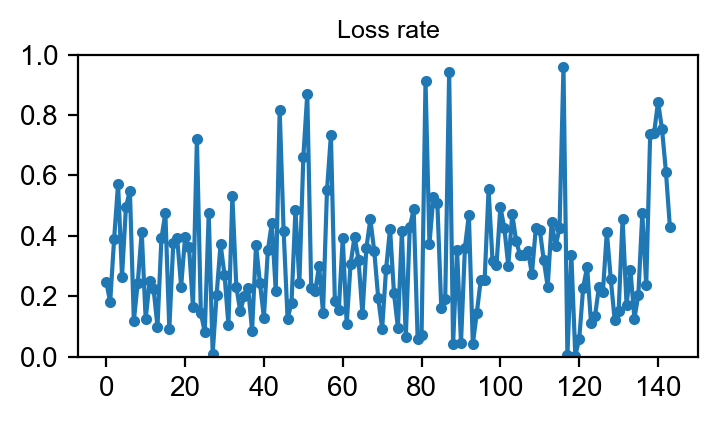

In [17]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,len(median_distmap),20))
ax.set_ylim([0,1])
ax.set_title(f"Loss rate", fontsize=9)
plt.show()

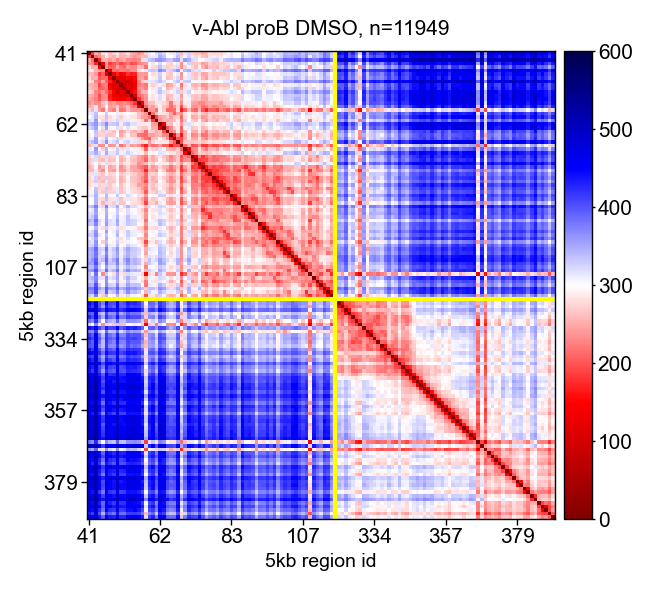

In [18]:
imaging_order = []
for _fd, _infos in fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            imaging_order.append(list(dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
#kept_inds = imaging_order # plot imaging ordered regions

kept_inds = np.where(loss_rates<0.6)[0] # plot good regions only

#kept_inds = np.arange(len(fov.unique_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"v-Abl proB DMSO, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)


ax.axvline(x=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])
ax.axhline(y=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

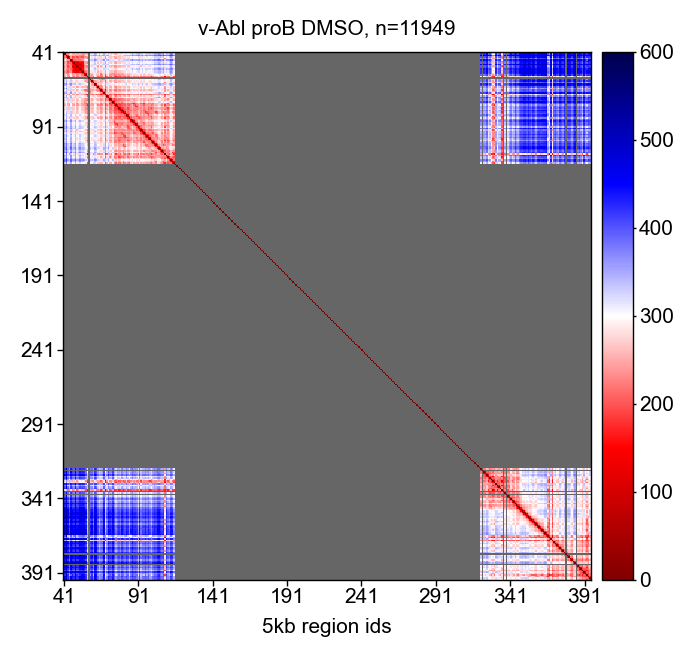

In [19]:
# generate full distmap
full_size = np.max(dna_reg_ids) - np.min(dna_reg_ids)+1

full_median_distmap = np.ones([full_size, full_size])*np.nan
full_median_distmap[np.arange(full_size), np.arange(full_size)] = np.zeros(len(full_median_distmap))
for _i, _id in enumerate(dna_reg_ids-np.min(dna_reg_ids)):
    full_median_distmap[_id, dna_reg_ids-np.min(dna_reg_ids)] = median_distmap[_i]
    

import matplotlib
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.4,0.4,0.4,1])

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(full_median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               cmap=median_cmap,
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0, np.max(dna_reg_ids)-np.min(dna_reg_ids), 50),
                                               tick_labels=np.arange(np.min(dna_reg_ids), np.max(dna_reg_ids),50), 
                                               figure_dpi=200)

ax.set_title(f"v-Abl proB DMSO, n={len(distmap_list)}", fontsize=7.5)
ax.set_xlabel(f"5kb region ids", fontsize=7.5)
plt.show()

## visualize single chromosome

<IPython.core.display.Javascript object>


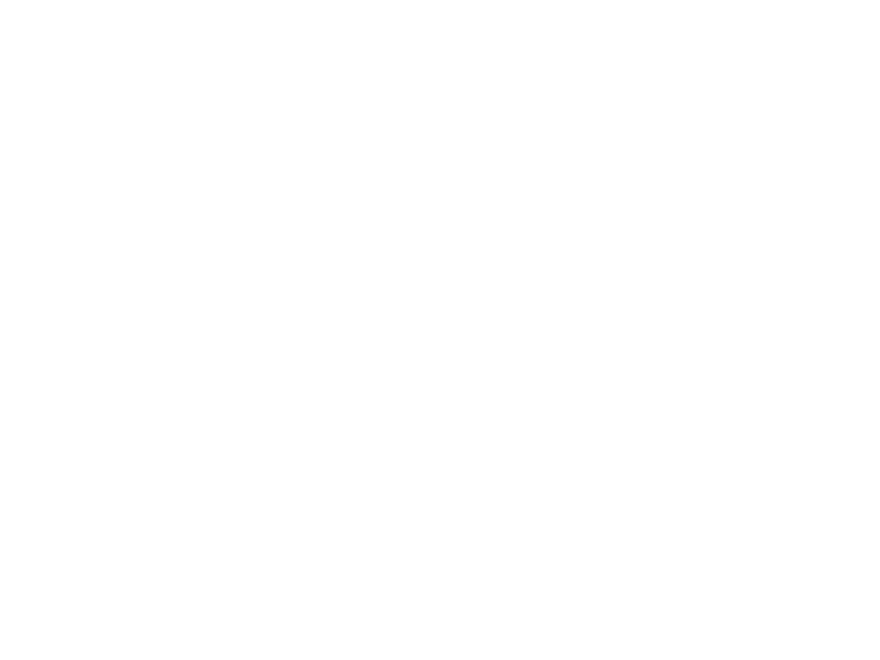

<IPython.core.display.Javascript object>


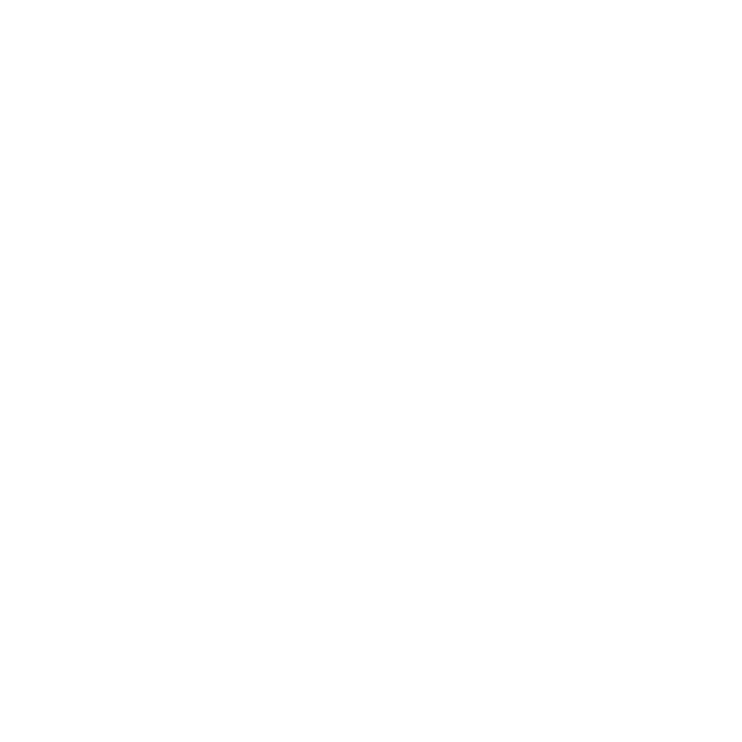

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x000002D6AACDBCC0>


<IPython.core.display.Javascript object>


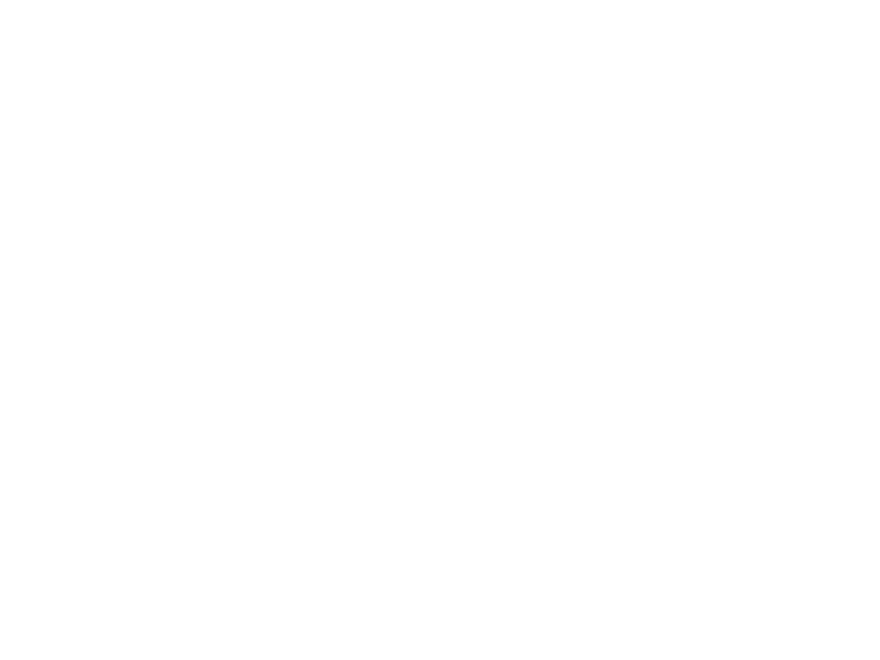

<IPython.core.display.Javascript object>


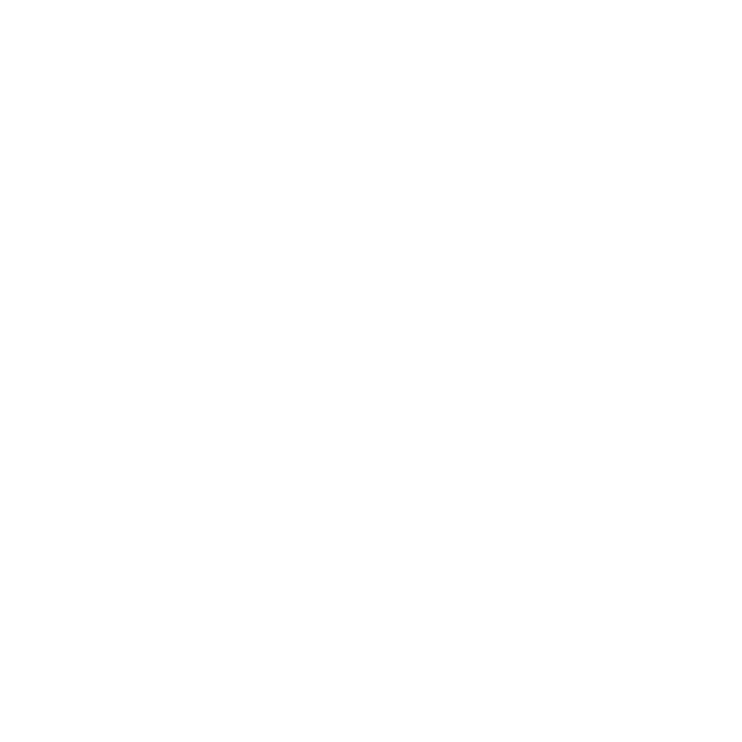

In [20]:
%matplotlib notebook

reload(figure_tools.image)

chrom_id = 1

import matplotlib
import copy

sc_cmap = copy.copy(matplotlib.cm.get_cmap('seismic_r'))
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])

#valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]
valid_inds = np.ones(len(final_dna_hzxys_list[chrom_id]), dtype=np.bool) # all spots

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(
        distmap_list[chrom_id][valid_inds][:,valid_inds], 
        color_limits=[0,400],
        ax=ax,
        cmap=sc_cmap,
        ticks=np.arange(0,150,20), 
        figure_dpi=200)
ax.set_title(f"v-Abl proB DMSO chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

ax3d = figure_tools.image.chromosome_structure_3d_rendering(
        final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
        marker_edge_line_width=0,
        reference_bar_length=200, image_radius=100, 
        line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

# Save to a temp file

In [21]:
# save picked_spots
overwrite_savefile = True

save_filename = os.path.join(fov.save_folder, f"Picked_spots_fov_{np.min(kept_fov_ids)}-{np.max(kept_fov_ids)}.pkl")

if not os.path.exists(save_filename) or overwrite_savefile:
    # assemble data dict
    picked_data = {
        'hzxys': final_dna_hzxys_list,
        'chrom_coords':kept_chrom_coords,
        'sel_scores': [_s for _s, _flag in zip(sel_dna_scores_list[-1], kept_chr_ids) if _flag],
        'other_scores': [_s for _s, _flag in zip(other_dna_scores_list[-1], kept_chr_ids) if _flag],
        'fov_ids': kept_fov_ids,
        'intensity_th': int_th,
        'score_th': score_th,
        'parameters': fov.shared_parameters,
    }
    picked_data['Notes'] = "Saved on April 7th, 2021\n"

    # save
    print(f"save to file: {save_filename}")
    pickle.dump(picked_data, open(save_filename, 'wb'))

save to file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20210326_IgH_proB_DMSO\Picked_spots_fov_3-22.pkl


In [43]:
len(picked_data['sel_scores'])

5628

187.37310329656003


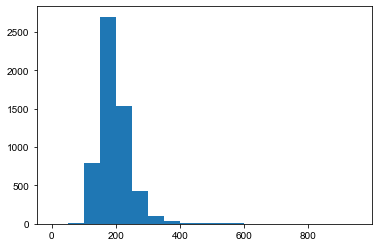

In [47]:
#radius of gyration
rgs = [spot_tools.scoring.radius_of_gyration(_hzxys[:72,1:]) for _hzxys in final_dna_hzxys_list]
print(np.median(rgs))
plt.figure()
plt.hist(rgs, bins=np.arange(0,1000,50))
plt.show()